In [1]:
using Plots
using Distributions
using Random, DataFrames
using LinearAlgebra
using MLJ, MLJLinearModels
using Hyperopt
include("src/qsrfe.jl")
using .qsrfe

In [12]:
bX, bY = @load_boston
df = DataFrame(bX)
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
Y = (bY .- mean(bY)) ./ std(bY)
(xtrain, xtest), (ytrain, ytest) = partition((bX, bY), 0.3, rng=123, multi=true)

(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.387913293767325 -0.5073242348197996 … 2.1242117472026987 -0.3617590047480517; -0.5066730008428395 -0.5073242348197996 … 2.0160737571861294 -0.4310662332073734], [-0.4431919238073216 -0.5073242348197996 … 2.0063827753861276 -0.37158365526253606; -0.5066456655907278 -0.5073242348197996 … 1.9900083578619874 -0.4273235092018555; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  24.6, 29.0, 24.7, 16.5, 27.0, 9.7, 15.0, 32.5, 10.2, 20.0], [12.1, 20.0, 13.8, 36.1, 20.6, 19.1, 30.1, 23.6, 22.3, 22.0  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

In [10]:
df

Row,Crim,Zn,Indus,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98
2,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14
3,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
4,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
5,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33
6,0.02985,0.0,2.18,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
7,0.08829,12.5,7.87,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43
8,0.14455,12.5,7.87,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15
9,0.21124,12.5,7.87,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93


In [13]:
model = qsrfe.srfeRegressor(N=1000,λ=0.003)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain)
ypred = qsrfe.predict(model,xtest,c, ω, ζ)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)

MSE: 38.29386370977359 train MSE: 5.920224929193398
rel: 0.21541268926600632 train rel: 0.07794984123453276


In [16]:
model = qsrfe.srfeRegressor(N=16384,λ=0.003)
quantizer = qsrfe.MSQ(K=2)
#quantizer = qsrfe.ΣΔQ(K=2,r=1,λ=2,condense=false)
quantizer = qsrfe.βQ(K=2,β=1.2,λ=16,condense=true)
c, ω, ζ = qsrfe.fit(model,xtrain,ytrain,quantizer)
ypred = qsrfe.predict(model,xtest,c, ω, ζ, quantizer)
ytrainpred = qsrfe.predict(model,xtrain,c, ω, ζ,quantizer)
qsrfe.test_metrics(ytest,ypred,ytrain,ytrainpred)

MSE: 18.62143498824433 train MSE: 29.130822971708504
rel: 0.15986626200355517 train rel: 0.17154797183271334


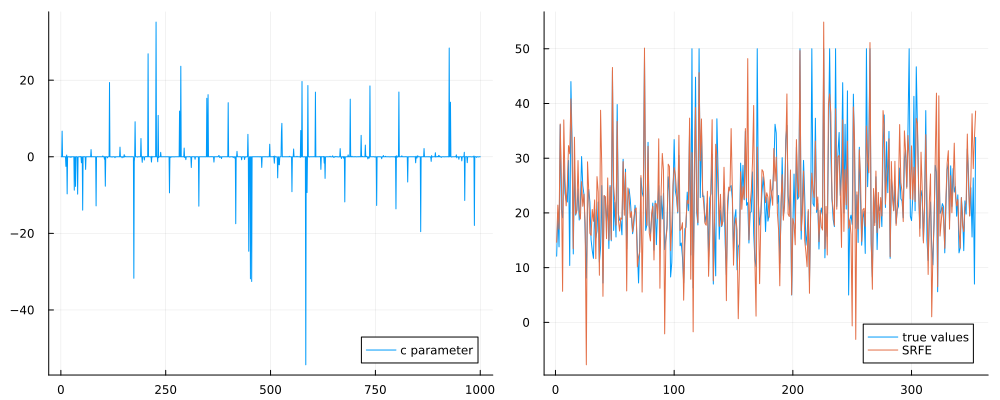

In [14]:
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(ypred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))
